---------------------------


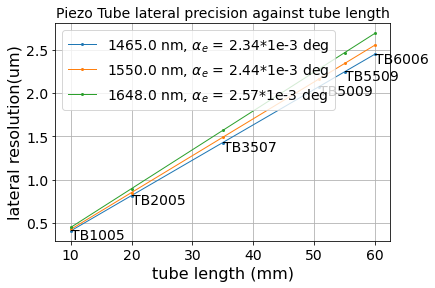

---------------------------


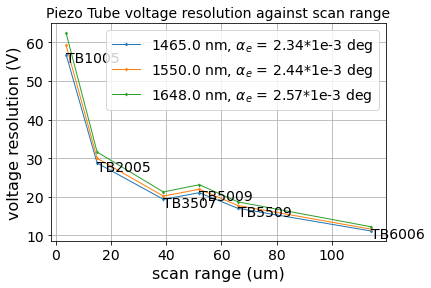

---------------------------


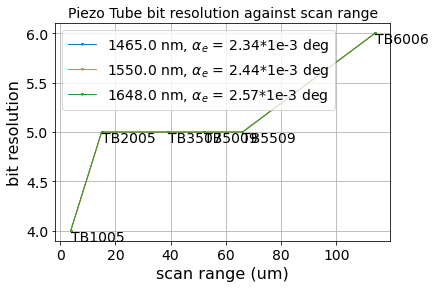

In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


# From previous angular_loss we can find the angular error (alpha_e) at 1 lens to generate 0.1dB loss
# This alpha_e can be correspondingly transformed into 3 reslutions required by an actuator:
# - lateral resolution (dx): the lateral movement that corresponds to this alpha_e by small angle analysis (bending tube)
# - voltage resolution (Vx): to generate this lateral reolution we need Vx = 2 *(abs(max_voltage)/scan_range) for each tube
# - bit resolution: assuming DAC has a step size of dx, then this is the least number of bits required to cover full scan range 



import sys
sys.path.append('..') 

import importlib
import modified_matrix_tracer
importlib.reload(modified_matrix_tracer)

from modified_matrix_tracer import GaussianBeam, FreeSpaceIterator, ThinLens, Misalignment
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from cycler import cycler
import numpy as np
import operator
from math import log, ceil, floor


# In[2]:


#find bit resolution in the nearest ceiling power
# Number of steps = scan range/lateral deviation
# bit resolution = next_ceil_power2(Number of steps)

def next_ceil_power2_new(num):

    ceil_power = ceil(np.log2(num))
    return ceil_power


# In[ ]:





# In[3]:


SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# In[4]:



#6 Types of Tube specifications
# Each type has correspondingly a tube length, scan range, max voltage by its index
# https://www.piezodrive.com/actuators/piezoelectric-tube-scanners/
L_tube_vec = [10.00*1e-3, 20.00*1e-3, 35.00*1e-3, 50.8*1e-3, 55*1e-3, 60*1e-3]

scan_range_vec = [3.8*1e-6, 15*1e-6, 39*1e-6, 52*1e-6, 66*1e-6, 114*1e-6]

max_voltage_vec = [264, 264, 264, 264, 250, 260]

#corresponding product number
tube_label_vec = ['TB1005', 'TB2005', 'TB3507', 'TB5009', 'TB5509', 'TB6006']

#working range
wavelength_vec = [1465*1e-9, 1550*1e-9, 1648*1e-9]

#tilt angle to reach 0.1dB loss for each of the 3 wavelength, respectively 
alpha_t_deg_vec = [2.34*1e-3, 2.44*1e-3, 2.57*1e-3] #deg
alpha_t_rad_vec = [np.radians(x) for x in alpha_t_deg_vec]


# In[5]:




delta_x_allwavelength = {}
voltage_res_allwavelength = {}
bit_res_allwavelength = {}
legend_label_all_wavelength = {}

for wavelength, alpha_t_rad in zip(wavelength_vec, alpha_t_rad_vec):
    
    #angle if approximate tube length as arc
    vartheta = 2*alpha_t_rad
    
    #actuator lateral movement resolution
    delta_x_vec = []
    
    #voltage to control this lateral movement resolution
    voltage_res_vec = []
    
    #bit resolution
    bit_res_vec  = []
    
    for L_tube, scan_range, max_voltage in zip(L_tube_vec,scan_range_vec, max_voltage_vec) :
        
        #outer radius assuming Length of tube is the arc
        mathcal_R = L_tube/vartheta
        #lateral movement
        delta_x = mathcal_R*(1 - np.cos(vartheta))
   
        #voltage resolution
        Vx_res = 2*delta_x*max_voltage/scan_range
    
    
        #bit resolution
        #bit_res = next_ceil_power2(scan_range/delta_x)
        bit_res = next_ceil_power2_new(scan_range/delta_x)
    
        delta_x_vec.append(delta_x)
        voltage_res_vec.append(Vx_res)
        bit_res_vec.append(bit_res)
    
    
    delta_x_allwavelength[wavelength] = delta_x_vec
    voltage_res_allwavelength[wavelength] = voltage_res_vec
    bit_res_allwavelength[wavelength] = bit_res_vec
    
    
    #legend_label = "{:.1f} nm, {}*1e3 deg".format(wavelength*1e9, np.degrees(alpha_t_rad)*1e3)
    legend_label = r'{:.1f} nm, $\alpha_e$ = {}*1e-3 deg'.format(wavelength*1e9, np.degrees(alpha_t_rad)*1e3)
    legend_label_all_wavelength[wavelength] = legend_label
    
    #plt.plot([x*1e3 for x in L_tube_vec], [x*1e6 for x in delta_x_vec], label = legend_label, marker='o')
    #plt.plot([x*1e3 for x in L_tube_vec], voltage_res_vec, label = legend_label, marker='d')
    #plt.plot([x*1e3 for x in L_tube_vec], bit_res_vec, label = legend_label, marker='v')
    
    

        


# In[6]:



#plot lateral resolution 
plt.figure()

for wavelength in delta_x_allwavelength.keys():
    plt.plot([x*1e3 for x in L_tube_vec], [x*1e6 for x in delta_x_allwavelength[wavelength]], label = legend_label_all_wavelength[wavelength], marker='o', linewidth=1, markersize=2)

for i, txt in enumerate(tube_label_vec):
    plt.annotate(txt, (L_tube_vec[i]*1e3, delta_x_allwavelength[1465*1e-09][i]*1e6 - 0.1))

plt.xlabel('tube length (mm)')
plt.ylabel('lateral resolution(um)')
plt.title('Piezo Tube lateral precision against tube length')
plt.legend(loc="upper left")
plt.grid()
print('---------------------------')
plt.show() 
                
  


    
    
    


# In[7]:


#plot voltage resolution

plt.figure()


for wavelength in voltage_res_allwavelength.keys():
    plt.plot([x*1e6 for x in scan_range_vec], voltage_res_allwavelength[wavelength], label = legend_label_all_wavelength[wavelength], marker='d', linewidth=1, markersize= 2)

for i, txt in enumerate(tube_label_vec):
    plt.annotate(txt, (scan_range_vec[i]*1e6, voltage_res_allwavelength[1465*1e-09][i] - 2))

plt.xlabel('scan range (um)')
plt.ylabel('voltage resolution (V)')
plt.title('Piezo Tube voltage resolution against scan range')
plt.legend(loc="upper right")
plt.grid()
print('---------------------------')
plt.show()  
    


# In[8]:


#plot bit resolution

plt.figure()

for wavelength in bit_res_allwavelength.keys():
    plt.plot([x*1e6 for x in scan_range_vec], bit_res_allwavelength[wavelength], label = legend_label_all_wavelength[wavelength], marker='v', linewidth=1, markersize= 2)

for i, txt in enumerate(tube_label_vec):
    plt.annotate(txt, (scan_range_vec[i]*1e6, bit_res_allwavelength[1465*1e-09][i]- 0.1))

plt.xlabel('scan range (um)')
plt.ylabel('bit resolution')
plt.title('Piezo Tube bit resolution against scan range')
plt.legend(loc="upper left")
plt.grid()
print('---------------------------')
plt.show()  









# In[ ]:



def next_ceil_power2(num):
    i = 1
    while i < num: i *= 2
        
    ceil_power = np.log2(i)
    return ceil_power

